**I)** Сначала простое решение. Берем колонки и обучаем на них лгб на трейн тест сплите.

In [2]:
import pandas as pd

tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

target = tr.target
tr = tr.drop(columns='target')

order_id = tst.order_id
tst = tst.drop(columns='order_id')

In [3]:
import pandas as pd
import numpy as np

def create_time_features(df, order_time_col='order_create_time', session_end_col='session_end_time'):
    """
    Создает новые временные признаки на основе колонок с временными метками.
    
    Параметры:
    df - DataFrame с данными
    order_time_col - название колонки с временем создания заказа (timestamp)
    session_end_col - название колонки с временем окончания сессии (timestamp)
    
    Возвращает:
    DataFrame с добавленными новыми признаками
    """
    df = df.copy()
    
    df[order_time_col] = pd.to_datetime(df[order_time_col])
    df[session_end_col] = pd.to_datetime(df[session_end_col])
    
    # 1. Разница между окончанием сессии и созданием заказа (в секундах)
    df['time_to_order_seconds'] = (df[session_end_col] - df[order_time_col]).dt.total_seconds()
    
    # 2. Признаки времени создания заказа
    df['order_hour'] = df[order_time_col].dt.hour
    df['order_day_of_week'] = df[order_time_col].dt.dayofweek  # 0-понедельник, 6-воскресенье
    df['order_day_of_month'] = df[order_time_col].dt.day
    df['order_month'] = df[order_time_col].dt.month
    df['order_week_of_year'] = df[order_time_col].dt.isocalendar().week
    df['order_is_weekend'] = df[order_time_col].dt.dayofweek >= 5
    
    # 3. Признаки времени окончания сессии
    df['session_end_hour'] = df[session_end_col].dt.hour
    df['session_end_day_of_week'] = df[session_end_col].dt.dayofweek
    df['session_end_day_of_month'] = df[session_end_col].dt.day
    df['session_end_month'] = df[session_end_col].dt.month
    df['session_end_week_of_year'] = df[session_end_col].dt.isocalendar().week
    df['session_end_is_weekend'] = df[session_end_col].dt.dayofweek >= 5
    
    # 4. Разница во времени в разных единицах
    df['time_to_order_minutes'] = df['time_to_order_seconds'] / 60
    df['time_to_order_hours'] = df['time_to_order_seconds'] / 3600
    
    # 5. Временные категории
    bins = [-1, 6, 12, 18, 23]
    labels = ['night', 'morning', 'afternoon', 'evening']
    df['order_time_of_day'] = pd.cut(df['order_hour'], bins=bins, labels=labels)
    df['session_end_time_of_day'] = pd.cut(df['session_end_hour'], bins=bins, labels=labels)
    
    # 6. Является ли заказ сделан в тот же день, что и сессия
    df['same_day_order'] = df[order_time_col].dt.date == df[session_end_col].dt.date
    
    # 7. Сезонность
    def get_season(month):
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:
            return 'autumn'
    
    df['order_season'] = df['order_month'].apply(get_season)
    df['session_end_season'] = df['session_end_month'].apply(get_season)
    
    return df

In [4]:
tr = create_time_features(tr)
tr = tr.drop(columns=['order_create_time', 'session_end_time'])

tst = create_time_features(tst)
tst = tst.drop(columns=['order_create_time', 'session_end_time'])

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

categorical_features = [
    'order_time_of_day', 
    'session_end_time_of_day',
    'order_season',
    'session_end_season',
    'order_is_weekend',
    'session_end_is_weekend',
    'same_day_order'
]

for col in ['order_season', 'session_end_season']:
    tr[col] = tr[col].astype('category')
    tst[col] = tst[col].astype('category')

'''for feature in categorical_features:
    if feature in tr.columns:
        le = LabelEncoder()
        # Объединяем train и test для консистентного кодирования
        combined = pd.concat([tr[feature], tst[feature]], axis=0)
        le.fit(combined.astype(str))
        tr[feature] = le.transform(tr[feature].astype(str))
        tst[feature] = le.transform(tst[feature].astype(str))
        
        # Указываем LightGBM, что это категориальные признаки
        tr[feature] = tr[feature].astype('category')
        tst[feature] = tst[feature].astype('category')'''

X_train, X_valid, y_train, y_valid = train_test_split(
    tr, target, test_size=0.2, random_state=42, stratify=target
)

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data, categorical_feature=categorical_features)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42,
    'early_stopping_round': 50
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[
		lgb.early_stopping(stopping_rounds=50, verbose=True),
		lgb.log_evaluation(period=50)
	]
)

val_pred = model.predict(X_valid)
val_auc = roc_auc_score(y_valid, val_pred)
print(f'Validation AUC: {val_auc:.4f}')

test_pred = model.predict(tst)

submission = pd.DataFrame({
    'order_id': order_id,
    'target': test_pred
})


submission.to_csv('simple_lgb.csv', index=False)

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.957483	valid's auc: 0.954893
[100]	train's auc: 0.960324	valid's auc: 0.956006
[150]	train's auc: 0.962937	valid's auc: 0.956309
[200]	train's auc: 0.965255	valid's auc: 0.956635
[250]	train's auc: 0.966934	valid's auc: 0.956623
Early stopping, best iteration is:
[207]	train's auc: 0.965457	valid's auc: 0.956672
Validation AUC: 0.9567


Посмотрим что по важности

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
import matplotlib as mpl
from matplotlib.patches import Patch
from typing import Optional, Literal

#TODO: Добавить предварительное сэмплирование, если на вход подан слишком большой датасет.
def plot_shap_beeswarm(
        df: pd.DataFrame,
        feature_names: Optional[list[str]] = None,
        shap_values: object = None,
        max_features: int = 20,
        cat_feature_threshold: float = 0.01,
        figsize: tuple[int, int] = (10, 6),
        n_samples: int = 1_000,
        palette_num: str | list = "coolwarm",
        palette_cat: str | list = "tab20",
        zero_line_color: str = "red",
        title: Optional[str] = None,
        rare_policy: Literal["combine", "drop"] = "combine",
        random_state: int = 8792,
        alpha: float = 0.7,
) -> pd.DataFrame:
    """
    Строит расширенный beeswarm-график SHAP значений с поддержкой категориальных признаков,
    отображением пропусков (NaN), цветовой нормализацией и контролируемой выборкой.
    Все уникальные значения категориальных признаков становятся отдельными признаками с именем в формате
    "родитель#категория".
    Для них строятся boxplot c усами по всему диапазону (min, max).
    Для категорий родителя вводится порог частоты для определения редких категорий (cat_feature_threshold).
    Если в параметре `rare_policy`='drop', то редкие категории удаляются, если 'combine', то создается
    признак "родитель#COMBINED_RARE".
    Все признаки, полученные от одного родителя, красятся в одинаковый цвет.

    :param df: Оригинальный DataFrame с признаками.
    :param feature_names: Список признаков для отображения. Если None — используются все.
    :param shap_values: SHAP-значения, соответствующие df по размеру (может быть DataFrame или ndarray).
    :param max_features: Максимальное количество признаков (или категорий) для отображения.
    :param cat_feature_threshold: Порог для определения редких категорий (по доле).
    :param figsize: Размер графика в дюймах (ширина, высота).
    :param n_samples: Количество наблюдений для отображения (сэмплируется).
    :param palette_num: Цветовая палитра или colormap для числовых признаков.
    :param palette_cat: Цветовая палитра для категориальных признаков.
    :param zero_line_color: Цвет вертикальной линии SHAP=0.
    :param title: Заголовок графика (опционально). Если None, то не отображается.
    :param rare_policy: Политика обработки редких категорий: 'combine' — объединить, 'drop' — удалить.
    :param random_state: Начальное значение генератора случайных чисел (для воспроизводимости).
    :param alpha: Прозрачность точек и boxplot (от 0 до 1).
    :return: DataFrame, содержащий точки для построения графика (после обработки и сэмплирования).
    """

    rng = np.random.default_rng(random_state)

    # Преобразуем SHAP-массив в DataFrame (если передан np.ndarray)
    if isinstance(shap_values, np.ndarray):
        shap_df = pd.DataFrame(shap_values, index=df.index, columns=df.columns)
    else:
        shap_df = shap_values.copy()

    # Проверка на соответствие форм и корректность параметров
    if shap_df.shape != df.shape:
        raise ValueError("Shape mismatch between df and shap_values.")
    if not (0 < cat_feature_threshold < 1):
        raise ValueError("cat_feature_threshold must be between 0 and 1.")
    if rare_policy not in {"combine", "drop"}:
        raise ValueError("rare_policy must be 'combine' or 'drop'.")
    if not (0 <= alpha <= 1):
        raise ValueError("alpha must be between 0 and 1.")

    # Сужаем датафрейм до выбранных признаков
    if feature_names:
        parents = [f for f in feature_names if f in df.columns]
    else:
        parents = list(df.columns)
    df = df[parents]
    shap_df = shap_df[parents]

    # Разделяем признаки на числовые и категориальные
    num_cols = [f for f in parents if df[f].dtype.name not in {"object","category"}]
    cat_cols = [f for f in parents if f not in num_cols]

    # Расширяем категориальные признаки: делаем отдельные колонки SHAP-значений на каждую категорию
    expanded = {}
    for f in cat_cols:
        series = df[f].astype(object)
        freq = series.value_counts(dropna=False, normalize=True)
        rare = freq[freq < cat_feature_threshold].index
        proc = series.where(~series.isin(rare), "COMBINED_RARE") if rare_policy=="combine" else series[~series.isin(rare)]
        proc = proc.fillna("NaN")
        shap_col = shap_df[f]
        for cat in proc.unique():
            expanded[f"{f}#{cat}"] = shap_col.where(proc==cat)

    # Для числовых признаков просто копируем SHAP значения
    for f in num_cols:
        expanded[f] = shap_df[f]
    shap_expanded = pd.DataFrame(expanded)

    # Сортировка признаков по среднему абсолютному SHAP влиянию
    mean_abs = shap_expanded.abs().mean().sort_values(ascending=False)
    ordered = list(mean_abs.index)[:max_features]

    # Подготовка данных для отображения: выборка сэмплов и нормализация
    records = []
    norm_map = {f: df[f].rank(pct=True) for f in num_cols} # приведение к равномерному распределению. TODO: потом сделаю умнее
    for feat in ordered:
        vals = shap_expanded[feat].dropna()
        idx = rng.choice(vals.index, min(len(vals), n_samples), replace=False)
        is_cat = feat not in num_cols
        for i in idx:
            base_feat = feat.split("#", 1)[0] if is_cat else feat
            orig_val = df[base_feat].loc[i]
            norm_val = np.nan if is_cat else norm_map[feat].loc[i]
            is_nan = pd.isna(orig_val)
            records.append({
                'feature': feat,
                'shap': vals.loc[i],
                'norm_val': norm_val,
                'is_cat': is_cat,
                'is_nan': is_nan,
                'cat_value': (feat.split('#', 1)[1] if is_cat else np.nan)
            })
    plot_df = pd.DataFrame(records)
    plot_df['feature'] = pd.Categorical(plot_df['feature'], categories=ordered, ordered=True)

    # Настройка цвета: градиент для числовых, цветовая палитра для категориальных
    num_norm = Normalize(vmin=0, vmax=1)
    cmap_num = mpl.colormaps.get_cmap(palette_num) if isinstance(palette_num,str) else palette_num
    parent_cat_features = sorted({c.split('#', 1)[0] for c in ordered if '#' in c})
    cat_palette_used = sns.color_palette(palette_cat, len(parent_cat_features)) if isinstance(palette_cat,str) else palette_cat
    parent_color_map = dict(zip(parent_cat_features, cat_palette_used))

    # Построение графика
    fig = plt.figure(figsize=figsize, constrained_layout=False)
    ax = fig.add_axes([0.05,0.15,0.6,0.75])

    # Boxplot'ы для категориальных признаков
    for i, feat in enumerate(ordered):
        if feat not in num_cols:
            dfc = plot_df[plot_df.feature==feat]
            parent = feat.split('#', 1)[0]
            vals = dfc.shap.values
            bp = ax.boxplot(
                vals,
                positions=[i],
                vert=False,
                widths=0.6,
                patch_artist=True,
                whis=(0, 100),
                zorder=2
            )
            for box in bp['boxes']:
                box.set_facecolor(parent_color_map[parent])
                box.set_alpha(alpha)
            for whisker in bp['whiskers']:
                whisker.set_color(parent_color_map[parent])
            for cap in bp['caps']:
                cap.set_color(parent_color_map[parent])
            for median in bp['medians']:
                median.set_color('black')

    # Scatter точки для числовых признаков: джиттер + отдельный рендер NaN
    for i, feat in enumerate(ordered):
        if feat in num_cols:
            # Точки с известными значениями
            df_num = plot_df[(plot_df.feature == feat) & (~plot_df.is_nan)]
            if not df_num.empty:
                y_jitter = i + (rng.random(len(df_num)) - 0.5) * 0.4
                ax.scatter(
                    df_num.shap,
                    y_jitter,
                    c=[cmap_num(num_norm(v)) for v in df_num.norm_val],
                    s=20,
                    alpha=alpha,
                    linewidths=0,
                    zorder=3
                )
            # Черные точки для NaN (без джиттера)
            df_nan_num = plot_df[(plot_df.feature == feat) & (plot_df.is_nan)]
            if not df_nan_num.empty:
                ax.scatter(
                    df_nan_num.shap,
                    [i] * len(df_nan_num),
                    c='black',
                    s=20,
                    alpha=alpha,
                    linewidths=0,
                    zorder=4
                )

    # Вертикальная линия SHAP = 0
    ax.axvline(0, color=zero_line_color, linewidth=1.5, zorder=1)

    # Подписи по оси Y
    y_labels=[]
    for feat in ordered:
        if '#' in feat:
            pre,cat=feat.split('#',1)
            safe_pre=pre.replace('_', '\\_').replace(' ', '\\ ')
            safe_cat=cat.replace('_', '\\_').replace(' ', '\\ ')
            y_labels.append(r"$\mathbf{"+safe_pre+r"}\#\mathrm{"+safe_cat+r"}$")
        else:
            sf=feat.replace('_','\\_').replace(' ','\\ ')
            y_labels.append(r"$\mathbf{"+sf+r"}$")
    ax.set_yticks(range(len(ordered)))
    ax.set_yticklabels(y_labels, fontsize=10)
    ax.invert_yaxis()
    ax.set_xlabel('SHAP values')
    ax.set_ylabel('Feature')
    ax.grid(axis='x', linestyle='--', alpha=0)
    if title:
        ax.set_title(title, fontsize=14)

    # Цветовая шкала для числовых признаков
    sm=mpl.cm.ScalarMappable(cmap=cmap_num, norm=num_norm)
    sm.set_array([])
    cax=fig.add_axes([0.68,0.15,0.02,0.75])
    cbar=fig.colorbar(sm, cax=cax)

    # Легенда для категорий и NaN
    legend_elems=[Patch(facecolor='black', label='NaN')]+[Patch(facecolor=parent_color_map[p], label=p) for p in parent_cat_features]
    fig.legend(
        handles=legend_elems,
        title='Categories',
        bbox_to_anchor=(0.75,0.5),
        loc='center left',
        frameon=False
    )

    return plot_df


c:\Users\Admin\anaconda3\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


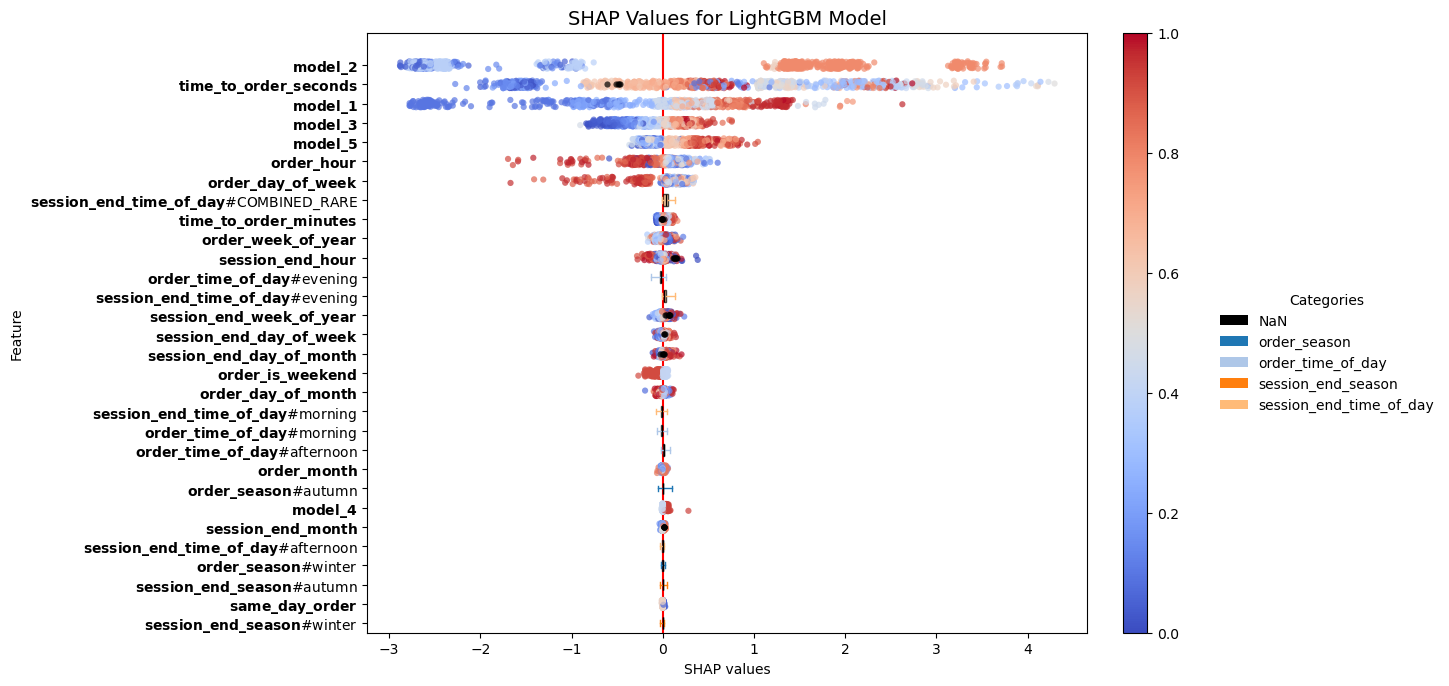

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

if isinstance(shap_values, list):
    shap_values = shap_values[1]

plot_df = plot_shap_beeswarm(
    df=X_valid,
    shap_values=shap_values,
    feature_names=categorical_features + list(X_valid.columns.difference(categorical_features)),
    max_features=30,
    cat_feature_threshold=0.05,
    figsize=(12, 8),
    n_samples=1000,
    title='SHAP Values for LightGBM Model'
)

4 модели и несколько временных признаков в топе, остальные мусор.

**II)** Далье проборвал разные модели, логрег, svm rbf, бустинги и так далее, но ничего не давало нормального результата.
Вспомнил, что целевая переменная называется is_callcenter и стал думать как это можно интерпретирвоать. Мне кажется, что вариантов очень много. Я выбрал такую гиппотизу - человек ползает по сайту, его перемешение записывается в сессию, а она заканчивается заказом. Так вот если человек "успешно" походил по сайту, то она сделает заказ либо до конца сессии, либо немного позже. А если нет, то он просто выберет, что ему нужно, и потом позвонит в коллцентр и сделает заказ там, в токаом случае разница между временем конца сессии и временем заказа будет большой по модулю. Или же эта идея совсем не правильная и звонок связан с какими то трудностями и так далее, эту гиппотизу я не проверял. 

Проверяем: идея такая - кто сильно не задерживается с заказам относительно конца сессии, тех предсказываем, остальным даем сразу единицу, считаем что они точно звонили.

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

# 1) Загрузка
tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

target = tr.pop('target')
order_id = tst.pop('order_id')

tr = create_time_features(tr)
tst = create_time_features(tst)

# удаляем исходные метки времени
tr = tr.drop(columns=['order_create_time', 'session_end_time'])
tst = tst.drop(columns=['order_create_time', 'session_end_time'])

# 2) Первый уровень: rule-based фильтр
threshold_hard = -2000
tr['hard_call'] = (tr['time_to_order_seconds'] < threshold_hard).astype(int)
tst['hard_call'] = (tst['time_to_order_seconds'] < threshold_hard).astype(int)

# 3) приводим object → category для ВСЕХ нужных колонок
#    это должны быть колонки из tr.select_dtypes(object) и session_end_time_of_day и т.п.
cat_cols = tr.select_dtypes(include=['object']).columns.tolist() + [
    'order_time_of_day', 'session_end_time_of_day'
]
cat_cols = list(set(cat_cols))  # убрать дубли

for col in cat_cols:
    # ТОЛЬКО если колонка есть в датафрейме
    if col in tr.columns:
        tr[col]  = tr[col].astype('category')
        tst[col] = tst[col].astype('category')

# 4) Разделяем на «сложные» и «очевидные» кейсы
mask = tr['hard_call'] == 0
X_soft = tr[mask]
y_soft = target[mask]

# 5) train/val split для «сложных»
X_train, X_val, y_train, y_val = train_test_split(
    X_soft, y_soft, test_size=0.2, stratify=y_soft, random_state=42
)

# 6) Dataset для LGBM
train_data = lgb.Dataset(
    X_train, label=y_train,
    categorical_feature=cat_cols
)
val_data = lgb.Dataset(
    X_val, label=y_val,
    categorical_feature=cat_cols,
    reference=train_data
)

# 7) Тренировка
params = {
    'objective':'binary', 'metric':'auc',
    'boosting_type':'gbdt', 'learning_rate':0.05,
    'num_leaves':31, 'feature_fraction':0.8,
    'bagging_fraction':0.8, 'bagging_freq':5,
    'max_depth':6, 'seed':42, 'verbose':-1
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[train_data, val_data],
    callbacks=[
		lgb.early_stopping(stopping_rounds=50, verbose=True),
		lgb.log_evaluation(period=50)
	],
)

print("Soft AUC:", roc_auc_score(y_val, model.predict(X_val)))

# 8) Финальный predict: rule-based + LGBM
def predict_full(df):
    # 1. если явный колл-центр
    preds = np.where(df['hard_call']==1,
                     1.0,
                     # 2. иначе моделью
                     model.predict(df, num_iteration=model.best_iteration))
    return preds

tst['pred'] = predict_full(tst)
tst['order_id'] = order_id
tst[['order_id','pred']].to_csv('submission.csv', index=False)


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.984653	valid_1's auc: 0.985363
[100]	training's auc: 0.986943	valid_1's auc: 0.986512
[150]	training's auc: 0.988987	valid_1's auc: 0.986655
Early stopping, best iteration is:
[121]	training's auc: 0.987724	valid_1's auc: 0.986766
Soft AUC: 0.9867656038764382



ROC-AUC: 0.9868


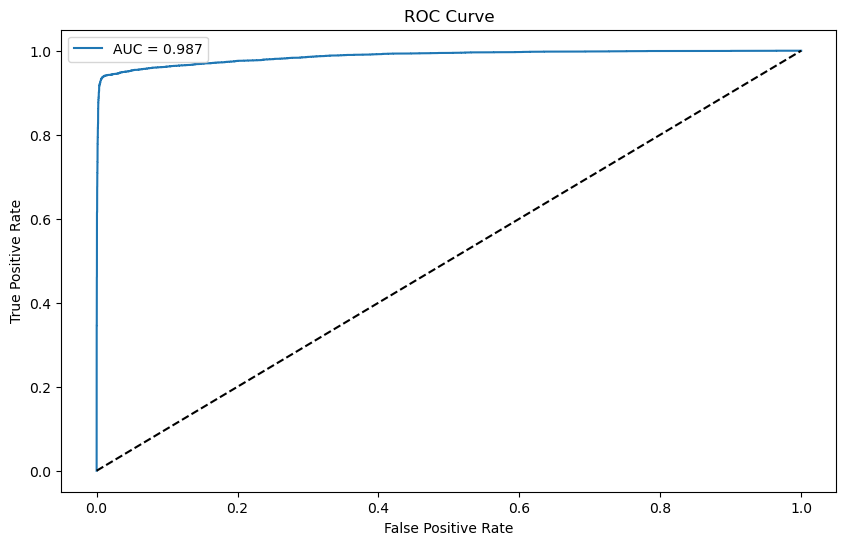

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

val_probs = model.predict(X_val, num_iteration=model.best_iteration)
roc_auc = roc_auc_score(y_val, val_probs)
print(f"\nROC-AUC: {roc_auc:.4f}")

# Визуализация ROC-кривой
fpr, tpr, _ = roc_curve(y_val, val_probs)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Full AUC: 0.7821928205255786


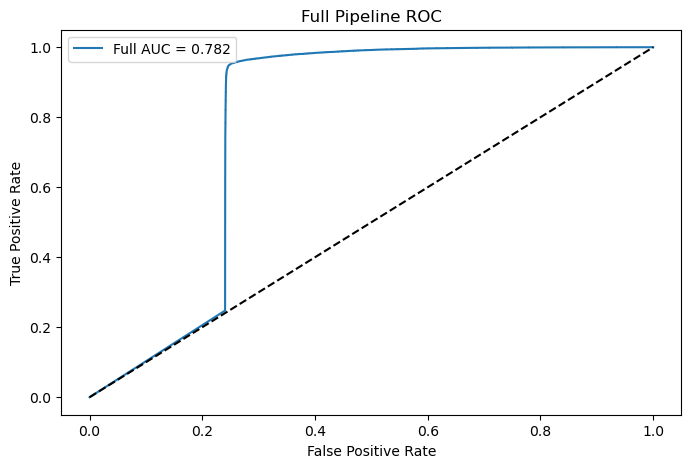

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve

# Предсказания для всего train
full_train_preds = predict_full(tr)      # та самая функция с rule+model
full_train_true  = target.values

# Общий ROC-AUC
auc_full = roc_auc_score(full_train_true, full_train_preds)
fpr, tpr, _ = roc_curve(full_train_true, full_train_preds)

print("Full AUC:", auc_full)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f'Full AUC = {auc_full:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Full Pipeline ROC')
plt.legend()
plt.show()


Выясняется, что давать единицу неправильно, там все не так тривиально и нужно искать другой подход. Возможно там просто сложные обьекты и лгб не успел на них доучиться? попробуем применить две разные модели

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

target = tr.pop('target')
order_id = tst.pop('order_id')

tr = create_time_features(tr)
tst = create_time_features(tst)

tr = tr.drop(columns=['order_create_time', 'session_end_time'])
tst = tst.drop(columns=['order_create_time', 'session_end_time'])

# 2) Первый уровень: rule-based фильтр
threshold_hard = -2000
tr['hard_call'] = (tr['time_to_order_seconds'] < threshold_hard).astype(int)
tst['hard_call'] = (tst['time_to_order_seconds'] < threshold_hard).astype(int)

cat_cols = tr.select_dtypes(include=['object']).columns.tolist() + [
    'order_time_of_day', 'session_end_time_of_day'
]
cat_cols = list(set(cat_cols))

for col in cat_cols:
    if col in tr.columns:
        tr[col]  = tr[col].astype('category')
        tst[col] = tst[col].astype('category')

# 4) Разделяем на «сложные» и «очевидные» кейсы
mask = tr['hard_call'] == 0
X_soft = tr[mask]
y_soft = target[mask]

#-------------------------------------------------------------------------
#-----------------------------------SOFT----------------------------------
#-------------------------------------------------------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_soft, y_soft, test_size=0.2, stratify=y_soft, random_state=42
)

train_data = lgb.Dataset(
    X_train, label=y_train,
    categorical_feature=cat_cols
)
val_data = lgb.Dataset(
    X_val, label=y_val,
    categorical_feature=cat_cols,
    reference=train_data
)

params = {
    'objective':'binary', 'metric':'auc',
    'boosting_type':'gbdt', 'learning_rate':0.05,
    'num_leaves':31, 'feature_fraction':0.8,
    'bagging_fraction':0.8, 'bagging_freq':5,
    'max_depth':6, 'seed':42, 'verbose':-1
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[train_data, val_data],
    callbacks=[
		lgb.early_stopping(stopping_rounds=50, verbose=True),
		lgb.log_evaluation(period=50)
	],
)

print("Soft AUC:", roc_auc_score(y_val, model.predict(X_val)))

#-------------------------------------------------------------------------
#-----------------------------------HARD----------------------------------
#-------------------------------------------------------------------------

X_hard = tr[~mask]  # где hard_call == 1
y_hard = target[~mask]

X_hard_train, X_hard_val, y_hard_train, y_hard_val = train_test_split(
    X_hard, y_hard, test_size=0.2, stratify=y_hard, random_state=42
)

train_data_hard = lgb.Dataset(
    X_hard_train, label=y_hard_train,
    categorical_feature=cat_cols
)
val_data_hard = lgb.Dataset(
    X_hard_val, label=y_hard_val,
    categorical_feature=cat_cols,
    reference=train_data_hard
)

# параметры получены из оптюны
params_hard = {
    'objective':'binary',
	'metric':'auc',
	'boosting_type':'gbdt',
	'learning_rate':0.047370678549250644,
	'num_leaves':3,
	'feature_fraction':0.6443136359902204,
	'bagging_fraction':0.7439504624342974,
	'bagging_freq':2,
	'max_depth':11,
    'min_child_samples': 64,
	'seed':42,
	'verbose':-1,
}

model_hard = lgb.train(
    params_hard,
    train_data_hard,
    num_boost_round=500,
    valid_sets=[train_data_hard, val_data_hard],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=50)
    ],
)

print("Hard AUC:", roc_auc_score(y_hard_val, model_hard.predict(X_hard_val)))




def predict_full(df):
    """
    Предсказывает is_callcenter, используя две модели:
    - LGB для 'легких' (hard_call == 0)
    - LGB для 'трудных' (hard_call == 1)
    """
    preds = np.zeros(df.shape[0])
    
    mask_hard = df['hard_call'] == 1
    mask_soft = ~mask_hard

    preds[mask_soft] = model.predict(df[mask_soft], num_iteration=model.best_iteration)
    preds[mask_hard] = model_hard.predict(df[mask_hard], num_iteration=model_hard.best_iteration)
    
    return preds


tst['pred'] = predict_full(tst)
tst['order_id'] = order_id
tst[['order_id','pred']].to_csv('submission.csv', index=False)


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.984653	valid_1's auc: 0.985363
[100]	training's auc: 0.986943	valid_1's auc: 0.986512
[150]	training's auc: 0.988987	valid_1's auc: 0.986655
Early stopping, best iteration is:
[121]	training's auc: 0.987724	valid_1's auc: 0.986766
Soft AUC: 0.9867656038764382
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.633601	valid_1's auc: 0.625128
[100]	training's auc: 0.641659	valid_1's auc: 0.635412
[150]	training's auc: 0.646863	valid_1's auc: 0.640317
[200]	training's auc: 0.650184	valid_1's auc: 0.643236
[250]	training's auc: 0.653437	valid_1's auc: 0.645634
[300]	training's auc: 0.656659	valid_1's auc: 0.647964
[350]	training's auc: 0.658842	valid_1's auc: 0.64996
[400]	training's auc: 0.661301	valid_1's auc: 0.651387
[450]	training's auc: 0.663275	valid_1's auc: 0.652919
[500]	training's auc: 0.665242	valid_1's auc: 0.653906
Did not meet early stopping. Best iteration is:

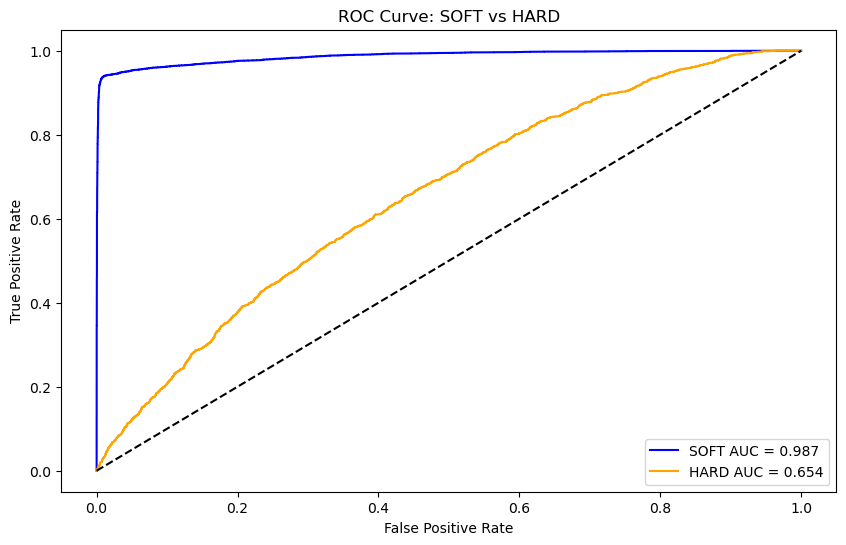

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# soft
val_probs = model.predict(X_val, num_iteration=model.best_iteration)
roc_auc = roc_auc_score(y_val, val_probs)
fpr, tpr, _ = roc_curve(y_val, val_probs)
plt.plot(fpr, tpr, label=f'SOFT AUC = {roc_auc:.3f}', color='blue')

# hard
hard_val_probs = model_hard.predict(X_hard_val, num_iteration=model_hard.best_iteration)
hard_roc_auc = roc_auc_score(y_hard_val, hard_val_probs)
fpr_hard, tpr_hard, _ = roc_curve(y_hard_val, hard_val_probs)
plt.plot(fpr_hard, tpr_hard, label=f'HARD AUC = {hard_roc_auc:.3f}', color='orange')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: SOFT vs HARD')
plt.legend()
plt.show()


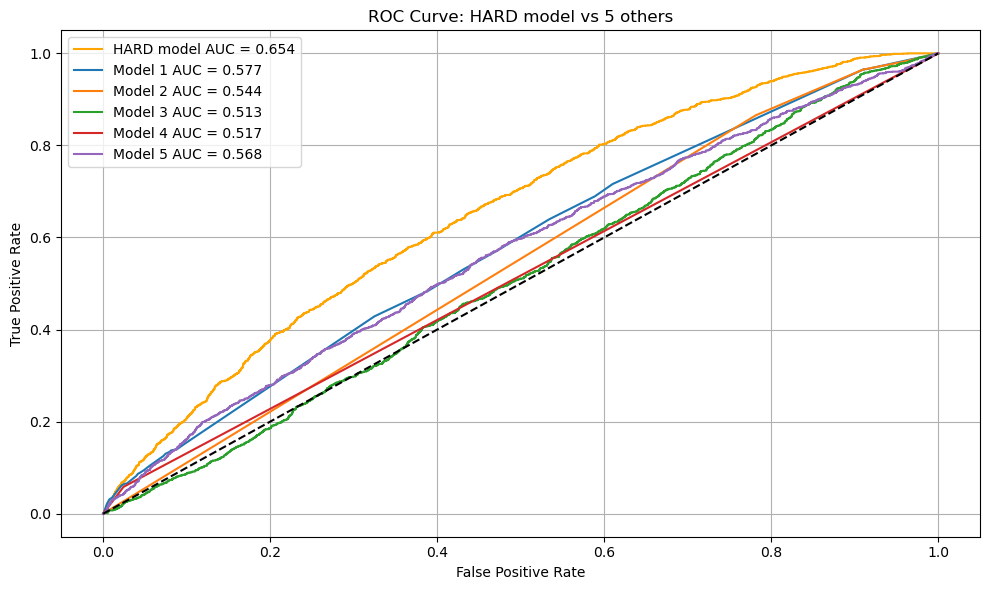

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Основная модель на HARD
hard_val_probs = model_hard.predict(X_hard_val, num_iteration=model_hard.best_iteration)
hard_roc_auc = roc_auc_score(y_hard_val, hard_val_probs)
fpr_hard, tpr_hard, _ = roc_curve(y_hard_val, hard_val_probs)
plt.plot(fpr_hard, tpr_hard, label=f'HARD model AUC = {hard_roc_auc:.3f}', color='orange')

# 5 "загадочных" моделей — предполагаем, что колонки называются model1 ... model5
for i in range(1, 6):
    col_name = f'model_{i}'
    if col_name in X_hard_val.columns:
        preds = X_hard_val[col_name]
        auc = roc_auc_score(y_hard_val, preds)
        fpr, tpr, _ = roc_curve(y_hard_val, preds)
        plt.plot(fpr, tpr, label=f'Model {i} AUC = {auc:.3f}')

# Диагональ случайного угадывания
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: HARD model vs 5 others')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Full AUC: 0.9593164015469016


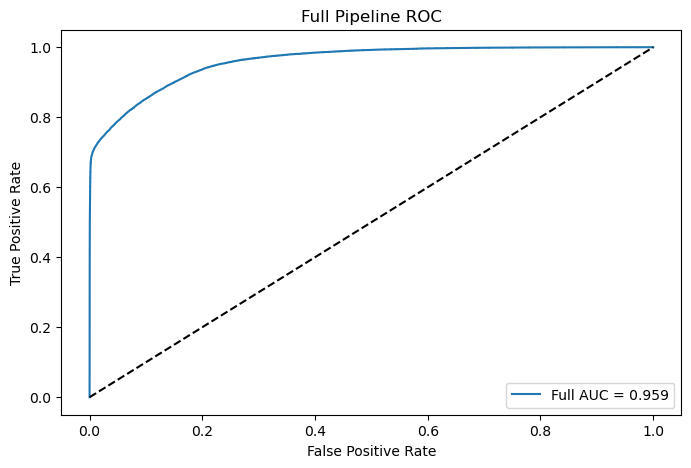

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve

# Предсказания для всего train
full_train_preds = predict_full(tr)      # та самая функция с rule+model
full_train_true  = target.values

# Общий ROC-AUC
auc_full = roc_auc_score(full_train_true, full_train_preds)
fpr, tpr, _ = roc_curve(full_train_true, full_train_preds)

print("Full AUC:", auc_full)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f'Full AUC = {auc_full:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Full Pipeline ROC')
plt.legend()
plt.show()


Нет, прироста это не дало, но оказывается, что сами базовые модели справляются на таких обьектах едва-едва, а некоторые и вовсе погибают. Выжать 0.99 будет невозможно, на этом отапе становиться понятно, что борьба будет идти за крошки. 

**III)** Другая идея - сделать алгос, который на каждом отрезке временной разницы определить лучшую модель. 

Мотивация - возможно какие то модели лучше предсказывают опреденные участки и там нужно использовать только их. 

Реализация - находим на отрезаках лучшую модель, делаем из этого новый признак и запихиваем его в уже известную реализацию лгб как новый кат признак.

Итог - ниче нового.

In [ ]:
tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

target = tr['target']
order_id = tst.pop('order_id')

tr = create_time_features(tr)
tst = create_time_features(tst)

tr = tr.drop(columns=['order_create_time', 'session_end_time'])
tst = tst.drop(columns=['order_create_time', 'session_end_time'])

tr['model_1'] = (tr['model_1'] - tr['model_1'].min()) / (tr['model_1'].max() - tr['model_1'].min())
tr['model_2'] = tr['model_2'].rank(pct=True)
tr['model_3'] = (tr['model_3'] - tr['model_3'].min()) / (tr['model_3'].max() - tr['model_3'].min())
tr['model_5'] = (tr['model_5'] - tr['model_5'].min()) / (tr['model_5'].max() - tr['model_5'].min())

tst['model_1'] = (tst['model_1'] - tst['model_1'].min()) / (tst['model_1'].max() - tst['model_1'].min())
tst['model_2'] = tst['model_2'].rank(pct=True)
tst['model_3'] = (tst['model_3'] - tst['model_3'].min()) / (tst['model_3'].max() - tst['model_3'].min())
tst['model_5'] = (tst['model_5'] - tst['model_5'].min()) / (tst['model_5'].max() - tst['model_5'].min())

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Границы зон
LEFT_TAIL_END = -70000
RIGHT_TAIL_START = 22000
WINDOW_SIZE = 1000
STEP = 1000

# Основная зона: скользящие окна
main_zone_models = {}
for window_start in np.arange(LEFT_TAIL_END, RIGHT_TAIL_START - WINDOW_SIZE, STEP):
    window_end = window_start + WINDOW_SIZE
    window_data = tr[tr['time_to_order_seconds'].between(window_start, window_end)]
    
    if window_data.empty or len(window_data['target'].unique()) < 2:
        continue
    
    max_auc = -1
    best_model = None
    for i in [1, 2, 3, 5]:
        col_name = f'model_{i}'
        if col_name not in window_data.columns:
            continue
        
        try:
            auc = roc_auc_score(window_data['target'], window_data[col_name])
        except ValueError:
            continue
        
        if auc > max_auc:
            max_auc = auc
            best_model = col_name
    
    if best_model:
        main_zone_models[(window_start + window_end) / 2] = best_model

# Левый хвост: одна модель на весь диапазон
left_tail_data = tr[tr['time_to_order_seconds'] < LEFT_TAIL_END]
left_tail_model = None
if not left_tail_data.empty and len(left_tail_data['target'].unique()) >= 2:
    max_auc = -1
    for i in [1, 2, 3, 5]:
        col_name = f'model_{i}'
        if col_name not in left_tail_data.columns:
            continue
        
        try:
            auc = roc_auc_score(left_tail_data['target'], left_tail_data[col_name])
        except ValueError:
            continue
        
        if auc > max_auc:
            max_auc = auc
            left_tail_model = col_name

# Правый хвост: одна модель на весь диапазон
right_tail_data = tr[tr['time_to_order_seconds'] > RIGHT_TAIL_START]
right_tail_model = None
if not right_tail_data.empty and len(right_tail_data['target'].unique()) >= 2:
    max_auc = -1
    for i in [1, 2, 3, 5]:
        col_name = f'model_{i}'
        if col_name not in right_tail_data.columns:
            continue
        
        try:
            auc = roc_auc_score(right_tail_data['target'], right_tail_data[col_name])
        except ValueError:
            continue
        
        if auc > max_auc:
            max_auc = auc
            right_tail_model = col_name
            
print("Main zone models:", main_zone_models)
print("Left tail model:", left_tail_model)
print("Right tail model:", right_tail_model)

Main zone models: {-69500.0: 'model_3', -68500.0: 'model_2', -67500.0: 'model_3', -66500.0: 'model_2', -65500.0: 'model_3', -64500.0: 'model_5', -63500.0: 'model_5', -62500.0: 'model_3', -61500.0: 'model_1', -60500.0: 'model_5', -59500.0: 'model_5', -58500.0: 'model_5', -57500.0: 'model_3', -56500.0: 'model_3', -55500.0: 'model_5', -54500.0: 'model_5', -53500.0: 'model_3', -52500.0: 'model_1', -51500.0: 'model_1', -50500.0: 'model_5', -49500.0: 'model_3', -48500.0: 'model_3', -47500.0: 'model_5', -46500.0: 'model_5', -45500.0: 'model_1', -44500.0: 'model_2', -43500.0: 'model_3', -42500.0: 'model_3', -41500.0: 'model_1', -40500.0: 'model_5', -39500.0: 'model_5', -38500.0: 'model_1', -37500.0: 'model_5', -36500.0: 'model_1', -35500.0: 'model_2', -34500.0: 'model_1', -33500.0: 'model_1', -32500.0: 'model_3', -31500.0: 'model_2', -30500.0: 'model_3', -29500.0: 'model_1', -28500.0: 'model_2', -27500.0: 'model_5', -26500.0: 'model_3', -25500.0: 'model_1', -24500.0: 'model_5', -23500.0: 'mode

In [21]:
main_zone_models[6500] = 'model_3'
main_zone_models[7500] = 'model_3'
main_zone_models[8500] = 'model_3'
main_zone_models[9500] = 'model_3'

In [ ]:
def get_best_model(time, main_zone_models, left_tail_model, right_tail_model):
    if time < LEFT_TAIL_END:
        return left_tail_model
    elif time > RIGHT_TAIL_START:
        return right_tail_model
    else:
        # Находим ближайшее окно в основной зоне
        closest_time = min(main_zone_models.keys(), key=lambda x: abs(x - time))
        return main_zone_models[closest_time]

tr['best_model'] = tr['time_to_order_seconds'].apply(
    lambda x: get_best_model(x, main_zone_models, left_tail_model, right_tail_model)
)

tr['final_prediction'] = tr.apply(lambda row: row[row['best_model']], axis=1)
tr

,target,model_1,model_2,model_3,model_4,model_5,time_to_order_seconds,order_hour,order_day_of_week,order_day_of_month,...,session_end_is_weekend,time_to_order_minutes,time_to_order_hours,order_time_of_day,session_end_time_of_day,same_day_order,order_season,session_end_season,best_model,final_prediction
0,1,0.966529,0.787289,0.039867,1,0.430643,-544.607,9,4,26,...,False,-9.076783,-0.151280,morning,morning,True,winter,winter,model_1,0.966529
1,0,0.437858,0.382523,0.020901,0,0.177717,1926.407,10,4,26,...,False,32.106783,0.535113,morning,morning,True,winter,winter,model_3,0.020901
2,1,0.402382,0.787289,0.039834,0,0.432202,-75.483,11,3,25,...,False,-1.258050,-0.020968,morning,morning,True,winter,winter,model_1,0.402382
3,1,0.549299,0.787289,0.040051,0,0.432350,831.153,14,4,26,...,False,13.852550,0.230876,afternoon,afternoon,True,winter,winter,model_3,0.040051
4,0,0.000000,0.051413,0.020597,0,0.174237,-232.743,18,4,26,...,False,-3.879050,-0.064651,afternoon,afternoon,True,winter,winter,model_1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104590,1,0.356660,0.382523,0.020913,0,0.188771,2674.990,12,1,16,...,False,44.583167,0.743053,morning,morning,True,winter,winter,model_3,0.020913
104591,1,0.464438,0.382523,0.029850,0,0.175186,-41689.227,11,5,8,...,False,-694.820450,-11.580341,morning,evening,False,autumn,autumn,model_1,0.464438
104592,0,0.000000,0.051413,0.021180,0,0.191542,51.047,9,2,12,...,False,0.850783,0.014180,morning,morning,True,autumn,autumn,model_3,0.021180
104593,1,0.503576,0.787289,0.040839,0,0.452914,-304.027,17,0,10,...,False,-5.067117,-0.084452,afternoon,afternoon,True,autumn,autumn,model_1,0.503576


In [ ]:
def get_best_model(time, main_zone_models, left_tail_model, right_tail_model,
                   left_tail_end=-70000, right_tail_start=22000):
    if time < left_tail_end:
        return left_tail_model
    elif time > right_tail_start:
        return right_tail_model
    else:
        # Находим ближайшее окно в основной зоне
        closest_center = min(main_zone_models.keys(), key=lambda x: abs(x - time))
        return main_zone_models[closest_center]


tst['best_model'] = tst['time_to_order_seconds'].apply(
    lambda x: get_best_model(x, main_zone_models, left_tail_model, right_tail_model)
)

# В каждой строке подставляем предсказание соответствующей модели
tst['final_prediction'] = tst.apply(lambda row: row[row['best_model']], axis=1)

tst

,model_1,model_2,model_3,model_4,model_5,time_to_order_seconds,order_hour,order_day_of_week,order_day_of_month,order_month,...,session_end_is_weekend,time_to_order_minutes,time_to_order_hours,order_time_of_day,session_end_time_of_day,same_day_order,order_season,session_end_season,best_model,final_prediction
0,0.000000,0.150558,0.042697,1,0.445707,-248.133,15,3,5,2,...,False,-4.135550,-0.068926,afternoon,afternoon,True,winter,winter,model_1,0.000000
1,0.692124,0.406432,0.022516,1,0.192479,86.593,15,5,7,2,...,True,1.443217,0.024054,afternoon,afternoon,True,winter,winter,model_3,0.022516
2,0.489911,0.815829,0.070756,0,0.403555,-61738.523,11,4,6,2,...,False,-1028.975383,-17.149590,morning,afternoon,False,winter,winter,model_1,0.489911
3,0.121135,0.150558,0.088604,1,0.417743,-1010.753,11,3,5,2,...,False,-16.845883,-0.280765,morning,morning,True,winter,winter,model_1,0.121135
4,0.488870,0.815829,0.056447,0,0.414674,-34957.897,19,6,1,2,...,True,-582.631617,-9.710527,evening,morning,True,winter,winter,model_1,0.488870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17191,0.493412,0.815829,0.969118,0,0.198277,-630665.860,16,0,9,2,...,False,-10511.097667,-175.184961,afternoon,morning,False,winter,winter,model_5,0.198277
17192,0.000000,0.150558,0.043391,0,0.414673,-274.520,14,0,9,2,...,False,-4.575333,-0.076256,afternoon,afternoon,True,winter,winter,model_1,0.000000
17193,0.692124,0.815829,0.042408,1,0.429551,-548.593,18,0,9,2,...,False,-9.143217,-0.152387,afternoon,afternoon,True,winter,winter,model_1,0.692124
17194,0.000000,0.150558,0.044496,0,0.437049,-5822.847,17,3,12,2,...,False,-97.047450,-1.617457,afternoon,afternoon,True,winter,winter,model_1,0.000000


In [24]:
tr = tr.drop(columns=['target'])

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

categorical_features = [
    'order_time_of_day', 
    'session_end_time_of_day',
    'order_season',
    'session_end_season',
    'order_is_weekend',
    'session_end_is_weekend',
    'same_day_order',
    'best_model'
]

for col in ['order_season', 'session_end_season', 'best_model']:
    tr[col] = tr[col].astype('category')
    tst[col] = tst[col].astype('category')

X_train, X_valid, y_train, y_valid = train_test_split(
    tr, target, test_size=0.2, random_state=42, stratify=target
)

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data, categorical_feature=categorical_features)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42,
    'early_stopping_round': 50
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[
		lgb.early_stopping(stopping_rounds=50, verbose=True),
		lgb.log_evaluation(period=50)
	]
)

val_pred = model.predict(X_valid)
val_auc = roc_auc_score(y_valid, val_pred)
print(f'Validation AUC: {val_auc:.4f}')

test_pred = model.predict(tst)

submission = pd.DataFrame({
    'order_id': order_id,
    'target': test_pred
})

submission.to_csv('new_fuck_this_shit.csv', index=False)

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.958079	valid's auc: 0.956021
[100]	train's auc: 0.960758	valid's auc: 0.956865
[150]	train's auc: 0.963416	valid's auc: 0.957101
[200]	train's auc: 0.965605	valid's auc: 0.957349
[250]	train's auc: 0.967349	valid's auc: 0.957333
[300]	train's auc: 0.969005	valid's auc: 0.957371
Early stopping, best iteration is:
[261]	train's auc: 0.967766	valid's auc: 0.957426
Validation AUC: 0.9574


c:\Users\Admin\anaconda3\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


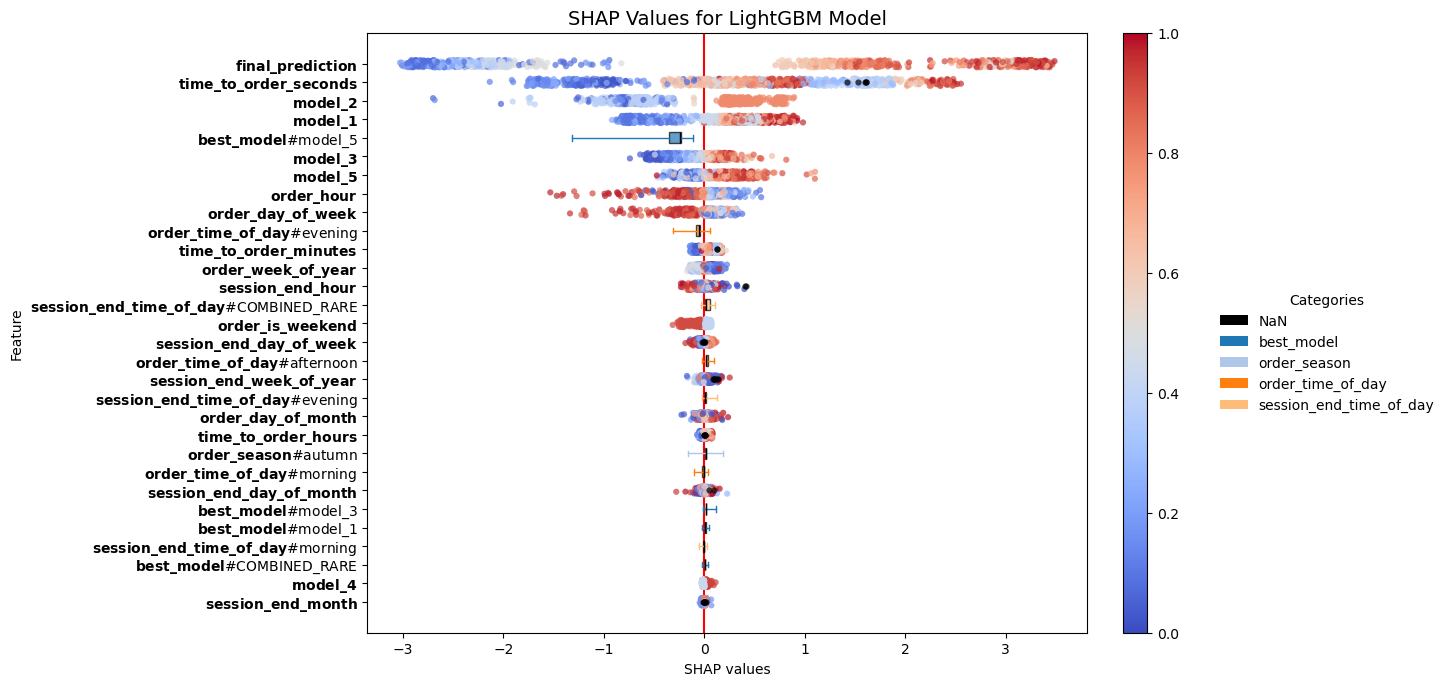

In [27]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

if isinstance(shap_values, list):
    shap_values = shap_values[1]

plot_df = plot_shap_beeswarm(
    df=X_valid,
    shap_values=shap_values,
    feature_names=categorical_features + list(X_valid.columns.difference(categorical_features)),
    max_features=30,
    cat_feature_threshold=0.05,
    figsize=(12, 8),
    n_samples=1000,
    title='SHAP Values for LightGBM Model'
)

Качество на трейне стало получше, а на сабмите похуже, видимо он переобучился немного. Модель особо не пользуется признеаком. Была еще идея на основе лучшихъ моделей сделать новый столбцец предсказаний и обучить на нем метамодель, но времени уже нет...

**IV)** Попробуем применить кластеризацию. Идея такая - заведем переменную, это будет 0-1 в зависимости от того, перевалила ли разность конце сессии и заказа за определлный порог. Проверим коррелацию этой переменной и таргета, на основе их проведем кластеризацию.

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt


tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

target = tr.pop('target')
order_id = tst.pop('order_id')

tr['time_to_order_seconds'] = (tr['session_end_time'] - tr['order_create_time']).dt.total_seconds()
tst['time_to_order_seconds'] = (tst['session_end_time'] - tst['order_create_time']).dt.total_seconds()

tr = tr.drop(columns=['order_create_time', 'session_end_time'])
tst = tst.drop(columns=['order_create_time', 'session_end_time'])

threshold_hard = -400
tr['hard_call'] = (tr['time_to_order_seconds'] < threshold_hard).astype(int)
tst['hard_call'] = (tst['time_to_order_seconds'] < threshold_hard).astype(int)

In [52]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


features = ['time_to_order_seconds', 'hard_call']

tr2 = tr.copy()
tr2['is_test'] = 0

tr2['target'] = target

tr2['label'] = tr2['target'].astype(str) + '_' + tr2['hard_call'].astype(str)

tst2 = tst.copy()
tst2['is_test'] = 1
tst2['label'] = 'test'

full = pd.concat([
    tr2[features + ['is_test','label']],
    tst2[features + ['is_test','label']]
], axis=0)

#Делим на группы по label и делаем подвыборку
np.random.seed(42)
samples = []
for lbl, size in [('0_0', 50), ('0_1', 50), ('1_0', 50), ('1_1', 50)]:
    grp = full[full['label']==lbl]
    samples.append(grp.sample(min(size, len(grp)), random_state=42))
    
# для теста
grp_test = full[full['label']=='test']
samples.append(grp_test.sample(min(100, len(grp_test)), random_state=42))

sub = pd.concat(samples, axis=0)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(sub[features].fillna(-999999999))

#Запускаем t‑SNE на подвыборке
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
coords = tsne.fit_transform(scaled_features)

sub = sub.assign(
    tsne_1 = coords[:,0],
    tsne_2 = coords[:,1],
)

fig = px.scatter(
    sub,
    x='tsne_1',
    y='tsne_2',
    color='label',
    symbol='is_test',
    hover_data=features + ['is_test']
)
fig.update_layout(title='t-SNE на подвыборке train+test')
fig.show()


In [63]:
import base64
from IPython.display import Image, display, HTML

def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode()

# Конвертируем изображение в base64
knn1 = image_to_base64("C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw5\\knn1.jpg")
knn2 = image_to_base64("C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw5\\knn2.jpg")


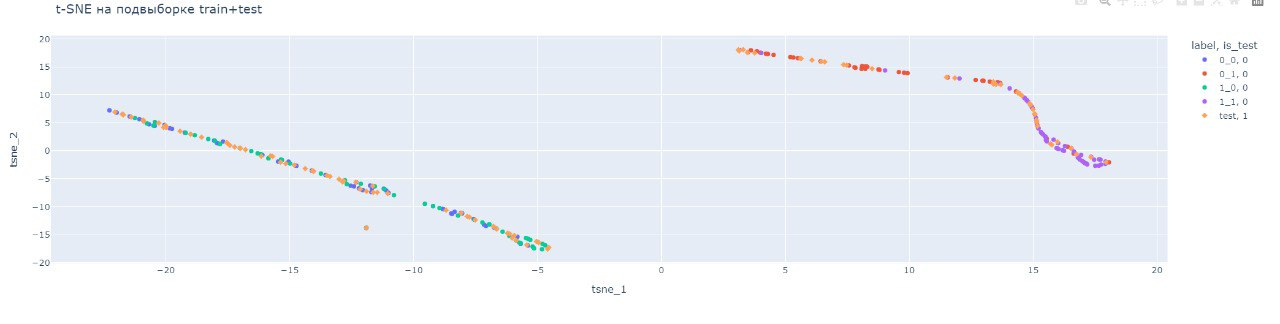

In [64]:
display(Image(url=f"data:image/jpg;base64,{knn1}"))

Метка *_* это обьединение, первое это значение таргет, а второе флаг того, что закапз сделан сильно позже конца сессии.

Тут обьедененные трейн и тест, но с пометками где кто. Видно что какое то разделение все таки есть. Теперь пробуем кнном выдать тесту новые метки и посмотреть что выйдет.

In [53]:
from sklearn.neighbors import KNeighborsClassifier


sub_train = sub[sub['is_test'] == 0].copy()
sub_test  = sub[sub['is_test'] == 1].copy()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(sub_train[features].fillna(-999999999))
X_test_scaled = scaler.transform(sub_test[features].fillna(-999999999))

# Обучаем KNN на подвыборке train
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(
    X_train_scaled,
    sub_train['label'].values
)

# Предсказываем для подвыборки test
sub_test['neighbor_label'] = knn.predict(X_test_scaled)

# 4) Объединяем обратно
sub_with_neighbors = pd.concat([sub_train, sub_test], axis=0)

# 5) Визуализируем с учетом neighbor_label
import plotly.express as px

fig = px.scatter(
    sub_with_neighbors,
    x='tsne_1', y='tsne_2',
    color='neighbor_label',    # теперь раскраска по KNN-метке
    symbol='is_test',
    hover_data=features + ['label', 'neighbor_label']
)
fig.update_layout(title='t-SNE на подвыборке + цвета от ближайших соседей')
fig.show()



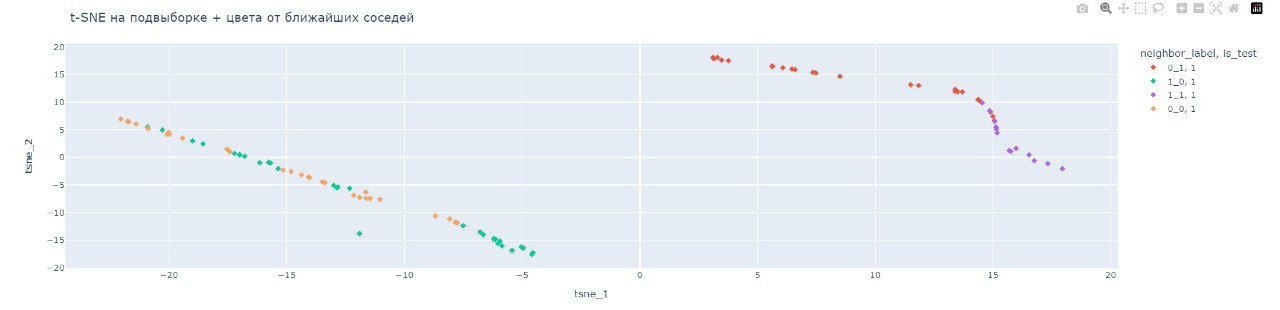

In [65]:
display(Image(url=f"data:image/jpg;base64,{knn2}"))

In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt


# 1) Загрузка
tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

target = tr.pop('target')
order_id = tst.pop('order_id')

tr['time_to_order_seconds'] = (tr['session_end_time'] - tr['order_create_time']).dt.total_seconds()
tst['time_to_order_seconds'] = (tst['session_end_time'] - tst['order_create_time']).dt.total_seconds()

# удаляем исходные метки времени
tr = tr.drop(columns=['order_create_time', 'session_end_time'])
tst = tst.drop(columns=['order_create_time', 'session_end_time'])

threshold_hard = -400
tr['hard_call'] = (tr['time_to_order_seconds'] < threshold_hard).astype(int)
tst['hard_call'] = (tst['time_to_order_seconds'] < threshold_hard).astype(int)

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score


tr2 = tr.copy()

tr2['target'] = target

tr2['label'] = tr2['target'].astype(str) + '_' + tr2['hard_call'].astype(str)

features = ['time_to_order_seconds', 'hard_call']

train_df, val_df = train_test_split(
    tr2,
    test_size=0.2,
    stratify=tr2['label'],
    random_state=42
)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[features].fillna(-999999999))
X_val = scaler.transform(val_df[features].fillna(-999999999))

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(
    train_df[features].fillna(-999999999).values,
    train_df['label'].values
)

# Предсказываем на валидации
val_pred_label = knn.predict(val_df[features].fillna(-999999999).values)


print("=== Отчёт по предсказанным меткам label ===")
print(classification_report(val_df['label'], val_pred_label))

true_target   = val_df['label'].str.split('_').str[0].astype(int).values
true_hardcall = val_df['label'].str.split('_').str[1].astype(int).values

pred_target   = pd.Series(val_pred_label).str.split('_').str[0].astype(int).values
pred_hardcall = pd.Series(val_pred_label).str.split('_').str[1].astype(int).values

print(f"Accuracy по target:     {accuracy_score(true_target,   pred_target):.4f}")
print(f"Accuracy по hard_call:  {accuracy_score(true_hardcall, pred_hardcall):.4f}")


=== Отчёт по предсказанным меткам label ===
              precision    recall  f1-score   support

         0_0       0.79      0.93      0.86      9760
         0_1       0.64      0.75      0.69      3739
         1_0       0.60      0.29      0.39      3379
         1_1       0.72      0.62      0.67      4041

    accuracy                           0.73     20919
   macro avg       0.69      0.65      0.65     20919
weighted avg       0.72      0.73      0.71     20919

Accuracy по target:     0.7346
Accuracy по hard_call:  1.0000


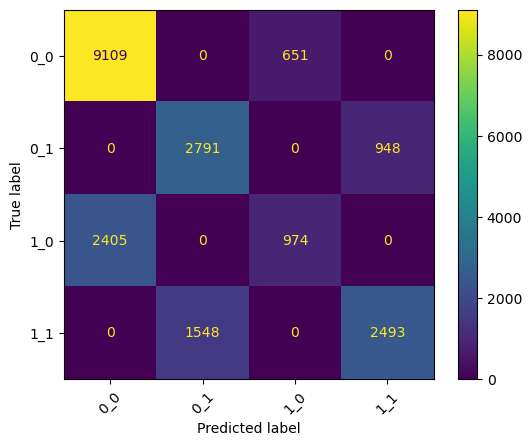

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(val_df['label'], val_pred_label, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(xticks_rotation=45)
plt.show()


Получаем такой себе результат, много ошибок, даже уичтывая то, что порог не такой и жесткий.

In [61]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

time_feats = ['model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'time_to_order_seconds', 'hard_call']

X_train, X_valid, y_train, y_valid = train_test_split(
    tr,
    target,
    test_size=0.2,
    random_state=42,
    stratify=target
)

train_knn = X_train.copy()

train_knn['target'] = target

train_knn['label'] = (
    train_knn['target'].astype(str) + '_' +
    train_knn['hard_call'].astype(int).astype(str)
)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(
    train_knn[time_feats].fillna(-999999999).values,
    train_knn['label'].values
)

X_train = X_train.copy()
X_train['knn_pred_target'] = train_knn['target'].astype(int)

X_valid = X_valid.copy()
knn_labels_valid = knn.predict(
    X_valid[time_feats].fillna(-999999999).values
)

X_valid['knn_pred_target'] = (
    pd.Series(knn_labels_valid)
      .str.split('_').str[0]
      .astype(int)
      .values
)

all_feats = time_feats + ['knn_pred_target']

train_data = lgb.Dataset(
    X_train[all_feats], label=y_train,
)
valid_data = lgb.Dataset(
    X_valid[all_feats], label=y_valid,
    reference=train_data,
)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_child_samples': 20,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train','valid'],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(50)
    ]
)

val_pred = model.predict(X_valid[all_feats])
val_auc = roc_auc_score(y_valid, val_pred)
print(f'Validation AUC: {val_auc:.4f}')

# Для test сначала строим knn_pred_target тем же KNN:
tst = tst.copy()
knn_labels_test = knn.predict(
    tst[time_feats].fillna(-999999999).values
)
tst['knn_pred_target'] = (
    pd.Series(knn_labels_test)
      .str.split('_').str[0]
      .astype(int)
      .values
)

test_pred = model.predict(tst[all_feats])

submission = pd.DataFrame({
    'order_id': order_id,
    'target': test_pred
})
submission.to_csv('submission.csv', index=False)


Training until validation scores don't improve for 50 rounds
[50]	train's auc: 1	valid's auc: 0.942319
[100]	train's auc: 1	valid's auc: 0.942703
[150]	train's auc: 1	valid's auc: 0.94319
[200]	train's auc: 1	valid's auc: 0.943178
[250]	train's auc: 1	valid's auc: 0.943455
[300]	train's auc: 1	valid's auc: 0.943474
Early stopping, best iteration is:
[291]	train's auc: 1	valid's auc: 0.943505
Validation AUC: 0.9435


Скор не выделяется относительно других, результата нет, но картинки красивые.

Итого - максимум, что удалось выжать - это 0.9448 на лидерборде.